# Conversational AI with Rasa



In [1]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

In [2]:
import sys
python = sys.executable

In [3]:
import rasa_nlu
import rasa_core
import spacy

# print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("en")("Hello world!"))

Loading spaCy language model...
Hello world!


In [4]:
print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))

rasa_nlu: 1.3.7 rasa_core: 1.3.7


## Part 1: Adding natural language understanding

First thing our bot is going to learn is how to understand user messages. To do that, wer're going to build a first version of language understanding model with Rasa NLU. 

### Language Understanding


creating some training data here, grouping user messages by their `intent`s. The intent describes what the messages *mean*. This is the training data for our NLU model, one example per line. Entities are labeled using the markdown link syntex: `[entity value](entity_type)`:

In [5]:
nlu_md = """
## intent:greet
- hey I am [Peter](PERSON)
- hello there I am [Hans](PERSON)
- hi I am [Tom](PERSON)
- hello there
- good morning
- good evening
- moin
- hey there
- let's go
- hey dude
- goodmorning
- goodevening
- good afternoon

## intent:goodbye
- cu
- good by
- cee you later
- good night
- good afternoon
- bye
- goodbye
- have a nice day
- see you around
- bye bye
- see you later

## intent:mood_affirm
- yes
- indeed
- of course
- that sounds good
- correct

## intent:mood_deny
- no
- never
- I don't think so
- don't like that
- no way
- not really

## intent:mood_great
- perfect
- very good
- great
- amazing
- feeling like a king
- wonderful
- I am feeling very good
- I am great
- I am amazing
- I am going to save the world
- super
- extremely good
- so so perfect
- so good
- so perfect

## intent:mood_unhappy
- my day was horrible
- I am sad
- I don't feel very well
- I am disappointed
- super sad
- I'm so sad
- sad
- very sad
- unhappy
- bad
- very bad
- awful
- terrible
- not so good
- not very good
- extremly sad
- so saad
- so sad
"""

%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


NLU pipeline

In [6]:
config = """
language: "en"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_spacy"                   # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


### Train the Rasa NLU Model

trainin a model to recognise these intents, so that when e send a message like "hello" to your bot, it will recognise this as a `"greet"` intent.

In [7]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

# loading the nlu training samples
training_data = load_data("nlu.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.







INFO:tensorflow:Entry Point [tensor2tensor.envs.tic_tac_toe_env:TicTacToeEnv] registered with id [T2TEnv-TicTacToeEnv-v0]




INFO:rasa.nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa.nlu.components:Added 'SpacyNLP' to component cache. Key 'SpacyNLP-en'.
INFO:rasa_nlu.model:Starting to train component SpacyNLP
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component SpacyTokenizer
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component SpacyEntityExtractor
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nl

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.2s finished
C:\Users\Khizar Shabir\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Successfully saved model into 'C:\Users\Khizar Shabir\Desktop\Rasa\models\nlu\current'


### Use & evaluate the NLU model
shooting it some messages:

In [8]:
pprint(interpreter.parse("i am good"))

{
  "intent": {
    "name": "mood_great",
    "confidence": 0.5917360272982893
  },
  "entities": [],
  "intent_ranking": [
    {
      "name": "mood_great",
      "confidence": 0.5917360272982893
    },
    {
      "name": "mood_unhappy",
      "confidence": 0.22134872061504735
    },
    {
      "name": "greet",
      "confidence": 0.08820980130626017
    },
    {
      "name": "goodbye",
      "confidence": 0.040600028979203145
    },
    {
      "name": "mood_deny",
      "confidence": 0.03809003580992461
    },
    {
      "name": "mood_affirm",
      "confidence": 0.020015385991275524
    }
  ],
  "text": "i am good"
}


Instead of evaluating it by hand, the model can also be evaluated on a test data set (though for simplicity we are going to use the same for test and train):

In [9]:
from rasa_nlu.test import run_evaluation

run_evaluation("nlu.md", model_directory)

INFO:rasa.nlu.components:Added 'SpacyNLP' to component cache. Key 'SpacyNLP-en'.
INFO:rasa_nlu.test:Running model for predictions:
100%|██████████| 68/68 [00:01<00:00, 38.28it/s]
INFO:rasa_nlu.test:Intent evaluation results:
INFO:rasa_nlu.test:Intent Evaluation: Only considering those 68 examples that have a defined intent out of 68 examples
INFO:rasa_nlu.test:F1-Score:  0.9852163087457204
INFO:rasa_nlu.test:Precision: 0.986344537815126
INFO:rasa_nlu.test:Accuracy:  0.9852941176470589
INFO:rasa_nlu.test:Classification report: 
              precision    recall  f1-score   support

 mood_affirm       1.00      1.00      1.00         5
  mood_great       1.00      1.00      1.00        15
     goodbye       1.00      0.91      0.95        11
   mood_deny       1.00      1.00      1.00         6
mood_unhappy       1.00      1.00      1.00        18
       greet       0.93      1.00      0.96        13

   micro avg       0.99      0.99      0.99        68
   macro avg       0.99      0.98

{'intent_evaluation': {'predictions': [{'text': 'hey I am Peter',
    'intent': 'greet',
    'predicted': 'greet',
    'confidence': 0.6066249388951286},
   {'text': 'hello there I am Hans',
    'intent': 'greet',
    'predicted': 'greet',
    'confidence': 0.5785254158054647},
   {'text': 'hi I am Tom',
    'intent': 'greet',
    'predicted': 'greet',
    'confidence': 0.5941665385377588},
   {'text': 'hello there',
    'intent': 'greet',
    'predicted': 'greet',
    'confidence': 0.5935034988091926},
   {'text': 'good morning',
    'intent': 'greet',
    'predicted': 'greet',
    'confidence': 0.5774176568051291},
   {'text': 'good evening',
    'intent': 'greet',
    'predicted': 'greet',
    'confidence': 0.5786272607008116},
   {'text': 'moin',
    'intent': 'greet',
    'predicted': 'greet',
    'confidence': 0.6215034653409723},
   {'text': 'hey there',
    'intent': 'greet',
    'predicted': 'greet',
    'confidence': 0.5583923538626409},
   {'text': "let's go",
    'intent': 

# Part 2: Adding dialogue capabilities

### Writing Stories



In [10]:
stories_md = """
## happy path               <!-- name of the story - just for debugging -->
* greet              
  - utter_greet
* mood_great               <!-- user utterance, in format intent[entities] -->
  - utter_happy
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_goodbye
  
## sad path 1               <!-- this is already the start of the next story -->
* greet
  - utter_greet             <!-- action the bot should execute -->
* mood_unhappy
  - utter_cheer_up
  - utter_did_that_help
* mood_affirm
  - utter_happy

## sad path 2
* greet
  - utter_greet
* mood_unhappy

  - utter_cheer_up
  - utter_did_that_help
* mood_deny
  - utter_goodbye
  
## strange user
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_unclear

## say goodbye
* goodbye
  - utter_goodbye

## fallback
- utter_unclear

"""

%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


### Defining a Domain

The domain specifies the universe that your bot lives in. You should list all of the intents and actions that show up in your stories. 
This is also the place to write templates, which contain the messages your bot can send back

In [11]:
domain_yml = """
intents:
- greet
- goodbye
- mood_affirm
- mood_deny
- mood_great
- mood_unhappy



actions:
- utter_greet
- utter_cheer_up
- utter_did_that_help
- utter_happy
- utter_goodbye
- utter_unclear


templates:
  utter_greet:
  - text: "Hey! How are you?"

  utter_cheer_up:
  - text: "You only live once"

  utter_did_that_help:
  - text: "Did that help you?"

  utter_unclear:
  - text: "I am not sure what you are aiming for."
  
  utter_happy:
  - text: "Great carry on!"

  utter_goodbye:
  - text: "Bye"
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


### Adding Custom API methods

In [12]:
from rasa_core.actions import Action
from rasa_core.events import SlotSet

import requests

# - __main__.ApiAction
class ApiAction(Action):
    def name(self):
        return "action_retrieve_image"

    def run(self, dispatcher, tracker, domain):
        dispatcher.utter_message("looking for a good img")
        url = "https://picsum.photos/200/300/?random"
        return [SlotSet("img_api_response", url)]  

### Pro Tip: Visualising the Training Data

You can visualise the stories to get a sense of how the conversations go. This is usually a good way to see if there are any stories which don't make sense


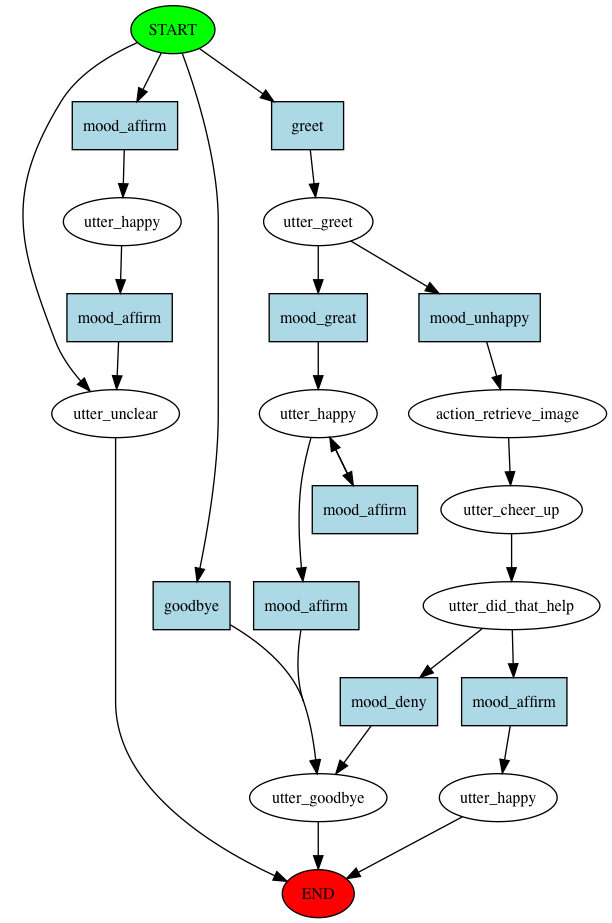

In [13]:
from IPython.display import Image
from rasa_core.agent import Agent

agent = Agent('domain.yml')
agent.visualize("stories.md", "story_graph.png", max_history=2)
Image(filename="story_graph.png")

### Training your Dialogue Model

We're going to show Rasa Core the stories we wrote above, and train a model on these examples. 
In this case, the model is a neural network implemented in Keras which learns to predict which action to take next. 

In [14]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent
import asyncio

# this will catch predictions the model isn't very certain about
# there is a threshold for the NLU predictions as well as the action predictions
fallback = FallbackPolicy(fallback_action_name="utter_unclear",
                          core_threshold=0.2,
                          nlu_threshold=0.5)

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy(validation_split=0.0, epochs=400), fallback])

# loading our neatly defined training dialogues
training_data = 'stories.md'

# loop = asyncio.get_event_loop()
# data = loop.run_until_complete(agent.load_data(training_data))
training_data = await agent.load_data(training_data)
agent.train(training_data)

agent.persist('models/dialogue')

INFO:rasa.core.policies.ensemble:MappingPolicy not included in policy ensemble. Default intents 'restart and back will not trigger actions 'action_restart' and 'action_back'.
Processed trackers: 100%|██████████| 6/6 [00:00<00:00, 35.72it/s, # actions=23]
Processed actions: 23it [00:00, 230.06it/s, # examples=23]
Processed trackers: 100%|██████████| 293/293 [00:15<00:00, 18.65it/s, # actions=237]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 5, 20)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6784      
_________________________________________________________________
dense (Dense)                (None, 14)                462       
_________________________________________________________________
activation (Activation)      (None, 14)                0         
Total params: 7,246
Trainable params: 7,246
Non-trainable params: 0
_________________________________________________________________


INFO:rasa.core.policies.keras_policy:Fitting model with 237 total samples and a validation split of 0.0


Epoch 1/400
237/237 [==============================] - ETA: 19s - loss: 2.6442 - acc: 0.0000e+ - ETA: 8s - loss: 2.6225 - acc: 0.0156     - ETA: 2s - loss: 2.6057 - acc: 0.046 - ETA: 0s - loss: 2.5802 - acc: 0.147 - 4s 15ms/sample - loss: 2.5769 - acc: 0.1603
Epoch 2/400
237/237 [==============================] - ETA: 0s - loss: 2.4972 - acc: 0.500 - ETA: 0s - loss: 2.4816 - acc: 0.401 - 0s 388us/sample - loss: 2.4690 - acc: 0.4346
Epoch 3/400
237/237 [==============================] - ETA: 0s - loss: 2.3551 - acc: 0.625 - ETA: 0s - loss: 2.3668 - acc: 0.462 - 0s 439us/sample - loss: 2.3531 - acc: 0.4768
Epoch 4/400
237/237 [==============================] - ETA: 0s - loss: 2.2255 - acc: 0.625 - ETA: 0s - loss: 2.2564 - acc: 0.447 - 0s 388us/sample - loss: 2.2226 - acc: 0.4768
Epoch 5/400
237/237 [==============================] - ETA: 0s - loss: 2.0084 - acc: 0.625 - ETA: 0s - loss: 2.1005 - acc: 0.447 - 0s 439us/sample - loss: 2.0694 - acc: 0.4768
Epoch 6/400
237/237 [===============

Epoch 47/400
237/237 [==============================] - ETA: 0s - loss: 0.6091 - acc: 0.875 - ETA: 0s - loss: 0.6825 - acc: 0.857 - 0s 354us/sample - loss: 0.6825 - acc: 0.8523
Epoch 48/400
237/237 [==============================] - ETA: 0s - loss: 0.5544 - acc: 0.937 - 0s 287us/sample - loss: 0.6704 - acc: 0.8523
Epoch 49/400
237/237 [==============================] - ETA: 0s - loss: 0.5417 - acc: 0.906 - 0s 287us/sample - loss: 0.6343 - acc: 0.8776
Epoch 50/400
237/237 [==============================] - ETA: 0s - loss: 0.4753 - acc: 0.906 - ETA: 0s - loss: 0.6353 - acc: 0.852 - 0s 354us/sample - loss: 0.6299 - acc: 0.8523
Epoch 51/400
237/237 [==============================] - ETA: 0s - loss: 0.5219 - acc: 0.875 - ETA: 0s - loss: 0.5880 - acc: 0.900 - 0s 456us/sample - loss: 0.6028 - acc: 0.8861
Epoch 52/400
237/237 [==============================] - ETA: 0s - loss: 0.4744 - acc: 0.906 - ETA: 0s - loss: 0.5827 - acc: 0.906 - 0s 337us/sample - loss: 0.5886 - acc: 0.8945
Epoch 53/400
2

237/237 [==============================] - ETA: 0s - loss: 0.1457 - acc: 0.968 - ETA: 0s - loss: 0.1801 - acc: 0.968 - 0s 337us/sample - loss: 0.1788 - acc: 0.9705
Epoch 94/400
237/237 [==============================] - ETA: 0s - loss: 0.2172 - acc: 0.937 - ETA: 0s - loss: 0.1842 - acc: 0.958 - 0s 388us/sample - loss: 0.1837 - acc: 0.9578
Epoch 95/400
237/237 [==============================] - ETA: 0s - loss: 0.1593 - acc: 0.968 - 0s 287us/sample - loss: 0.1921 - acc: 0.9747
Epoch 96/400
237/237 [==============================] - ETA: 0s - loss: 0.1470 - acc: 0.968 - 0s 287us/sample - loss: 0.1855 - acc: 0.9620
Epoch 97/400
237/237 [==============================] - ETA: 0s - loss: 0.0987 - acc: 1.000 - 0s 270us/sample - loss: 0.1675 - acc: 0.9789
Epoch 98/400
237/237 [==============================] - ETA: 0s - loss: 0.1248 - acc: 0.968 - ETA: 0s - loss: 0.1415 - acc: 0.995 - 0s 321us/sample - loss: 0.1441 - acc: 0.9916
Epoch 99/400
237/237 [==============================] - ETA: 0s -

Epoch 147/400
237/237 [==============================] - ETA: 0s - loss: 0.0717 - acc: 0.937 - 0s 270us/sample - loss: 0.0529 - acc: 0.9831
Epoch 148/400
237/237 [==============================] - ETA: 0s - loss: 0.1018 - acc: 0.968 - 0s 270us/sample - loss: 0.0965 - acc: 0.9705
Epoch 149/400
237/237 [==============================] - ETA: 0s - loss: 0.0563 - acc: 0.968 - ETA: 0s - loss: 0.0695 - acc: 0.986 - 0s 337us/sample - loss: 0.0708 - acc: 0.9831
Epoch 150/400
237/237 [==============================] - ETA: 0s - loss: 0.0683 - acc: 1.000 - 0s 270us/sample - loss: 0.0716 - acc: 0.9916
Epoch 151/400
237/237 [==============================] - ETA: 0s - loss: 0.0341 - acc: 1.000 - 0s 287us/sample - loss: 0.0471 - acc: 0.9958
Epoch 152/400
237/237 [==============================] - ETA: 0s - loss: 0.0825 - acc: 0.937 - 0s 305us/sample - loss: 0.0936 - acc: 0.9789
Epoch 153/400
237/237 [==============================] - ETA: 0s - loss: 0.0491 - acc: 1.000 - 0s 287us/sample - loss: 0.0

237/237 [==============================] - ETA: 0s - loss: 0.0129 - acc: 1.000 - ETA: 0s - loss: 0.0339 - acc: 0.995 - 0s 337us/sample - loss: 0.0327 - acc: 0.9958
Epoch 195/400
237/237 [==============================] - ETA: 0s - loss: 0.0076 - acc: 1.000 - ETA: 0s - loss: 0.0500 - acc: 0.991 - 0s 422us/sample - loss: 0.0478 - acc: 0.9916
Epoch 196/400
237/237 [==============================] - ETA: 0s - loss: 0.0188 - acc: 1.000 - ETA: 0s - loss: 0.0422 - acc: 0.989 - 0s 371us/sample - loss: 0.0501 - acc: 0.9873
Epoch 197/400
237/237 [==============================] - ETA: 0s - loss: 0.0220 - acc: 1.000 - ETA: 0s - loss: 0.0430 - acc: 0.991 - 0s 371us/sample - loss: 0.0447 - acc: 0.9873
Epoch 198/400
237/237 [==============================] - ETA: 0s - loss: 0.0215 - acc: 1.000 - ETA: 0s - loss: 0.0375 - acc: 0.995 - 0s 354us/sample - loss: 0.0366 - acc: 0.9958
Epoch 199/400
237/237 [==============================] - ETA: 0s - loss: 0.0528 - acc: 0.968 - ETA: 0s - loss: 0.0432 - acc:

Epoch 242/400
237/237 [==============================] - ETA: 0s - loss: 0.0391 - acc: 1.000 - ETA: 0s - loss: 0.0241 - acc: 1.000 - 0s 371us/sample - loss: 0.0358 - acc: 0.9958
Epoch 243/400
237/237 [==============================] - ETA: 0s - loss: 0.0121 - acc: 1.000 - ETA: 0s - loss: 0.0139 - acc: 1.000 - 0s 337us/sample - loss: 0.0178 - acc: 0.9958
Epoch 244/400
237/237 [==============================] - ETA: 0s - loss: 0.0109 - acc: 1.000 - 0s 287us/sample - loss: 0.0191 - acc: 0.9958
Epoch 245/400
237/237 [==============================] - ETA: 0s - loss: 0.0730 - acc: 0.968 - 0s 287us/sample - loss: 0.0319 - acc: 0.9916
Epoch 246/400
237/237 [==============================] - ETA: 0s - loss: 0.0208 - acc: 1.000 - ETA: 0s - loss: 0.0275 - acc: 0.995 - 0s 350us/sample - loss: 0.0263 - acc: 0.9958
Epoch 247/400
237/237 [==============================] - ETA: 0s - loss: 0.0384 - acc: 0.968 - 0s 287us/sample - loss: 0.0222 - acc: 0.9958
Epoch 248/400
237/237 [=======================

237/237 [==============================] - ETA: 0s - loss: 0.0043 - acc: 1.000 - ETA: 0s - loss: 0.0290 - acc: 0.995 - 0s 337us/sample - loss: 0.0276 - acc: 0.9958
Epoch 293/400
237/237 [==============================] - ETA: 0s - loss: 0.0050 - acc: 1.000 - ETA: 0s - loss: 0.0145 - acc: 0.995 - 0s 337us/sample - loss: 0.0152 - acc: 0.9958
Epoch 294/400
237/237 [==============================] - ETA: 0s - loss: 0.0060 - acc: 1.000 - ETA: 0s - loss: 0.0109 - acc: 1.000 - 0s 388us/sample - loss: 0.0116 - acc: 1.0000
Epoch 295/400
237/237 [==============================] - ETA: 0s - loss: 0.0135 - acc: 1.000 - 0s 281us/sample - loss: 0.0245 - acc: 0.9958
Epoch 296/400
237/237 [==============================] - ETA: 0s - loss: 0.0294 - acc: 1.000 - ETA: 0s - loss: 0.0195 - acc: 1.000 - 0s 354us/sample - loss: 0.0185 - acc: 1.0000
Epoch 297/400
237/237 [==============================] - ETA: 0s - loss: 0.0232 - acc: 1.000 - ETA: 0s - loss: 0.0255 - acc: 0.995 - 0s 337us/sample - loss: 0.024

237/237 [==============================] - ETA: 0s - loss: 0.0119 - acc: 1.000 - ETA: 0s - loss: 0.0226 - acc: 0.994 - 0s 422us/sample - loss: 0.0200 - acc: 0.9958
Epoch 339/400
237/237 [==============================] - ETA: 0s - loss: 0.0090 - acc: 1.000 - ETA: 0s - loss: 0.0073 - acc: 1.000 - 0s 472us/sample - loss: 0.0081 - acc: 1.0000
Epoch 340/400
237/237 [==============================] - ETA: 0s - loss: 0.0121 - acc: 1.000 - ETA: 0s - loss: 0.0329 - acc: 0.994 - 0s 383us/sample - loss: 0.0293 - acc: 0.9958
Epoch 341/400
237/237 [==============================] - ETA: 0s - loss: 0.0017 - acc: 1.000 - ETA: 0s - loss: 0.0301 - acc: 0.987 - 0s 445us/sample - loss: 0.0229 - acc: 0.9916
Epoch 342/400
237/237 [==============================] - ETA: 0s - loss: 0.0227 - acc: 1.000 - ETA: 0s - loss: 0.0148 - acc: 1.000 - 0s 489us/sample - loss: 0.0145 - acc: 1.0000
Epoch 343/400
237/237 [==============================] - ETA: 0s - loss: 0.0259 - acc: 1.000 - ETA: 0s - loss: 0.0384 - acc:

237/237 [==============================] - ETA: 0s - loss: 0.0085 - acc: 1.000 - ETA: 0s - loss: 0.0180 - acc: 0.992 - ETA: 0s - loss: 0.0129 - acc: 0.995 - 0s 574us/sample - loss: 0.0123 - acc: 0.9958
Epoch 384/400
237/237 [==============================] - ETA: 0s - loss: 0.0035 - acc: 1.000 - ETA: 0s - loss: 0.0086 - acc: 1.000 - 0s 456us/sample - loss: 0.0089 - acc: 1.0000
Epoch 385/400
237/237 [==============================] - ETA: 0s - loss: 0.0043 - acc: 1.000 - ETA: 0s - loss: 0.0028 - acc: 1.000 - 0s 405us/sample - loss: 0.0036 - acc: 1.0000
Epoch 386/400
237/237 [==============================] - ETA: 0s - loss: 0.0026 - acc: 1.000 - ETA: 0s - loss: 0.0150 - acc: 1.000 - 0s 370us/sample - loss: 0.0146 - acc: 1.0000
Epoch 387/400
237/237 [==============================] - ETA: 0s - loss: 0.0322 - acc: 0.968 - ETA: 0s - loss: 0.0123 - acc: 0.995 - 0s 371us/sample - loss: 0.0117 - acc: 0.9958
Epoch 388/400
237/237 [==============================] - ETA: 0s - loss: 8.2303e-04 - 

INFO:rasa.core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Model directory models/dialogue\core exists and contains old model files. All files will be overwritten.
INFO:rasa_core.agent:Persisted model to 'C:\Users\Khizar Shabir\Desktop\Rasa\models\dialogue\core'


### Starting up the bot (with NLU)

Now that we've trained the dialogue **and** language understanding models and saved them, we can start up an `Agent` which will handle conversations for us. 

In [15]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:rasa.core.policies.ensemble:MappingPolicy not included in policy ensemble. Default intents 'restart and back will not trigger actions 'action_restart' and 'action_back'.
INFO:rasa.nlu.components:Added 'SpacyNLP' to component cache. Key 'SpacyNLP-en'.


### Talking to the Bot (with NLU)

We can start talking to the bot in natural language.

In [17]:
print("Chatbot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
#     print (a)
    if a == 'stop':
        break
    responses = await agent.handle_text(a)
#     responses = dict (responses)
#     print (len(responses))
    for response in responses:
#         print (response)
        print(response["text"])


Chatbot is ready to talk! Type your messages here or send 'stop'
Good afternoon
Hey! How are you?
I am good
Great carry on!
I am unhappy
You only live once
Did that help you?
No
Bye
Why
I am not sure what you are aiming for.
stop
